# library

In [1]:
# %%capture
# # !pip install -q nnAudio
# !pip install -q --upgrade wandb
# !pip install -q grad-cam
# # !pip install -q ttach
# # !pip install efficientnet_pytorch
# # !pip install albumentations
# !pip install line_profiler
# !pip install transformers
# !pip install audiomentations
# !pip3 install pydub

In [2]:
# !pip install "ipykernel<6"
# !pip install "jupyterlab<3.1"

In [3]:
import os
import gc
import json
import random
from datetime import datetime
import time
import collections
import itertools
from itertools import chain, combinations
import sys
import json
import wandb
from collections import defaultdict
import h5py
from glob import glob
import pickle
import math

import scipy as sp
import numpy as np
np.set_printoptions(precision=5, suppress=True) 

import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import IPython.display
from tqdm.auto import tqdm
from skimage.transform import resize

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as torch_functional
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts,
                    CosineAnnealingLR, ReduceLROnPlateau,_LRScheduler,CyclicLR)
from torch.cuda.amp import autocast, GradScaler

from transformers import get_cosine_schedule_with_warmup

import audiomentations as A
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, PolarityInversion


/opt/conda/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
%load_ext line_profiler

# Configuration

In [5]:
class Config:

    #frequently changed 
    model_name = 'TCNN'
    model_version = "121st_V2SD_PL_6ep_2em3lr_32ch_vf+gn+sc01+tm+ts" 
    model_module = 'V2StochasticDepth'#V2StochasticDepth,ModelIafossV2
    use_pretrain = False
    use_pseudo_label = True
    up_thresh = 0.70
    down_thresh = 0.15

    debug = False
    use_checkpoint = False
    use_lr_finder = True
    use_subset = False 
    subset_frac = 0.4

    #preproc related
    #augmentation
    #proba for conservative, weight for aggressive
    
    #conservative
    conservative_aug = []#'vflip','add_gaussian_noise',
    #aggressive, OneOf 
    aggressive_aug_proba = 0.80
    aggressive_aug = ['vflip','add_gaussian_noise','shuffle01','timemask','time_shift',]     #'reduce_SNR'
    
    
    vflip = True
    vflip_proba = 0.5
    vflip_weight = 1.0 
    add_gaussian_noise = True 
    add_gaussian_noise_proba = 0.5 
    add_gaussian_noise_weight = 1.0    
    timemask = True
    timemask_proba = 0.35
    timemask_weight = 0.8
    shuffle01 = True
    shuffle01_proba = 0.35
    shuffle01_weight = 0.8
    time_shift = True
    time_shift_left = 96
    time_shift_right = 96
    time_shift_proba = 0.35
    time_shift_weight = 0.4
    
    shift_channel = False
    shift_channel_left = 16
    shift_channel_right = 16
    shift_channel_proba = 0.5
    shift_channel_weight = 1.0
    shift_two_channels = False #tba
    shift_two_channels_proba = 0.5
    shift_two_channels_weight= 1.0
    reduce_SNR = False
    reduce_SNR_ratio = 0.9998
    reduce_SNR_proba = 0.5
    reduce_SNR_weight = 1.0

    time_stretch = False
    divide_std = False 
    shuffle_channels = False    
    pitch_shift = False
    use_mixup = False
    mixup_alpha = 0.1
    cropping = False
    
    #logistic
    seed = 48
    target_size = 1
    target_col = 'target'
    n_fold = 5
#     gdrive = './drive/MyDrive/Kaggle/G2Net/input/'
    kaggle_json_path = 'kaggle/kaggle.json'
    output_dir = "G2Net-Model/"
    pseudo_label_folder = "G2Net-Model/main_112th_V2SD_PL_6ep_5Fold/"#main_35th_GeM_vflip_shuffle01_5fold,#main_112th_V2SD_PL_6ep_5Fold

    #logger
    print_num_steps=350
    
    #training related
    train_folds = [0,1,2,3,4]
    epochs = 6
    batch_size = 256
    
    lr=  2e-3 #2e-3#8e-3#1e-2#5e-3, 1e-2 # Optimizer  1e-2 channel8, 5e-3 or 2e-3 channel32, 7e-3 channel 16
    weight_decay=0 #1e-4  # Optimizer, default value 0.01
    gradient_accumulation_steps=1 # Optimizer
    scheduler='cosineWithWarmUp' # warm up ratio 0.1 of total steps 
     
    #speedup
    num_workers=7
    non_blocking=False
    amp=True
    use_cudnn = True 
    use_tpu = False
    use_ram = False
    continuous_exp = False
    
    #CNN structure
    channels = 32
    reduction = 4.0
    stochastic_final_layer_proba = 0.8

# no need to change below
Config.model_output_folder = Config.output_dir + Config.model_version + "/"
if not os.path.exists(Config.output_dir):
    os.mkdir(Config.output_dir)
if not os.path.exists(Config.model_output_folder):
    os.mkdir(Config.model_output_folder)

torch.backends.cudnn.benchmark = Config.use_cudnn 
display(Config.model_output_folder)

'G2Net-Model/122nd_V2_PL_6ep_2em3lr_32ch_vf+gn+sc01+tm+ts/'

In [6]:
# #run once for Fold 0, save it in RAM and then do experiments multiple times       
# if Config.continuous_exp and Config.train_folds == [0]:
#     start_time =time.time()  
#     if Config.use_pseudo_label:
#         with open('fold_0_data_PL.npy', 'rb') as f:
#             fold_0_data_PL = np.load(f)
#     else:
#         with open('fold_0_data.npy', 'rb') as f:
#             fold_0_data = np.load(f)
#     print(time.time()-start_time)

# wandb

In [7]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

save_object(class2dict(Config), Config.model_output_folder + "Config.pkl")

# Data path

In [8]:
def id_2_path(file_id: str, train=True) -> str:
    if train:
        return "./output/whiten-train-w0/{}.npy".format(file_id)
    else:
        return "./output/whiten-test-w0/{}.npy".format(file_id)

In [9]:
train_df = pd.read_csv('training_labels.csv')
test_df = pd.read_csv('sample_submission.csv')
if Config.debug:
    Config.epochs = 1
    train_df = train_df.sample(n=50000, random_state=Config.seed).reset_index(drop=True)
if Config.use_subset:
    train_df = train_df.sample(frac=Config.subset_frac, random_state=Config.seed).reset_index(drop=True)
train_df['file_path'] = train_df['id'].apply(lambda x :id_2_path(x))
test_df['file_path'] = test_df['id'].apply(lambda x :id_2_path(x,False))

In [10]:
# checking magnitude of waves
num_files = 5
input_file_paths = train_df['file_path'].values[:num_files]
batch_waves=np.zeros((num_files,3,4096))
for i,input_file_path in enumerate(input_file_paths[:num_files]):
    file_name = input_file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(input_file_path)#.astype(np.float32) # (3, 4096)
#     batch_waves[i,:] = np.array([waves.max(axis=1),np.abs(waves).max(axis=1),np.abs(waves).min(axis=1)])
    whitened_waves = waves#whiten(waves)
    print(whitened_waves[2][500])

-0.013057893
0.01869043
0.005618966
-0.01463365
0.010516807


In [11]:
# !!
skf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
splits = skf.split(train_df, train_df["target"])
train_df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(splits):
    train_df.loc[valid_index,"fold"] = fold
# train_df['fold_PL'] = train_df['fold']

train_df.groupby('fold')['target'].apply(lambda s: s.value_counts(normalize=True))

fold   
0     0    0.500125
      1    0.499875
1     0    0.500125
      1    0.499875
2     0    0.500125
      1    0.499875
3     0    0.500125
      1    0.499875
4     0    0.500125
      1    0.499875
Name: target, dtype: float64

In [12]:
train_df

,id,target,file_path,fold
0,00000e74ad,1,./output/whiten-train-w0/00000e74ad.npy,3
1,00001f4945,0,./output/whiten-train-w0/00001f4945.npy,0
2,0000661522,0,./output/whiten-train-w0/0000661522.npy,4
3,00007a006a,0,./output/whiten-train-w0/00007a006a.npy,0
4,0000a38978,1,./output/whiten-train-w0/0000a38978.npy,4
...,...,...,...,...
559995,ffff9a5645,1,./output/whiten-train-w0/ffff9a5645.npy,3
559996,ffffab0c27,0,./output/whiten-train-w0/ffffab0c27.npy,1
559997,ffffcf161a,1,./output/whiten-train-w0/ffffcf161a.npy,2
559998,ffffd2c403,0,./output/whiten-train-w0/ffffd2c403.npy,1


# Model

## dataset

In [13]:
conserv_transform_list = []
aggressive_transform_list = []
conserv_transform_list_strings = []
aggressive_transform_list_strings = []

#-------------------------vflip
if Config.vflip:
#     trans = lambda x:-x
    def vflip_func(x,sample_rate=2048):
        return -x
    def vflip_func_random(x,sample_rate=2048):
        if np.random.random()<Config.vflip_proba:
            return -x
        else:
            return x
    if 'vflip' in Config.aggressive_aug:
        aggressive_transform_list.append(vflip_func)
        aggressive_transform_list_strings.append('vflip')
    else:
        conserv_transform_list.append(vflip_func_random)
        conserv_transform_list_strings.append('vflip')
#----------------------add_gaussian_noise        
if Config.add_gaussian_noise:
    
    if 'add_gaussian_noise' in Config.aggressive_aug:
        trans = A.AddGaussianNoise(min_amplitude=0.001*0.015, max_amplitude=0.015*0.015, p=1) #tbs #0.015 is the estimated std
        aggressive_transform_list.append(trans)
        aggressive_transform_list_strings.append('add_gaussian_noise')
    else:
        trans = A.AddGaussianNoise(min_amplitude=0.001*0.015, max_amplitude=0.015*0.015, p=Config.add_gaussian_noise_proba) #tbs #0.015 is the estimated std
        conserv_transform_list.append(trans)
        conserv_transform_list_strings.append('add_gaussian_noise')

#--------------------------timemask
if Config.timemask:
    
    if 'timemask' in Config.aggressive_aug:
        trans = A.TimeMask(min_band_part=0.0, max_band_part=0.03, fade=False, p=1)
        aggressive_transform_list.append(trans)
        aggressive_transform_list_strings.append('timemask')
    else:
        trans = A.TimeMask(min_band_part=0.0, max_band_part=0.03, fade=False, p=Config.timemask_proba)
        conserv_transform_list.append(trans)
        conserv_transform_list_strings.append('timemask')

#--------------------------shuffle01        
def shuffle01_func(x,sample_rate=2048):
    return x[[1,0,2]]
def shuffle01_func_random(x,sample_rate=2048):
    if np.random.random()<Config.shuffle01_proba: 
        return x[[1,0,2]]
    else:
        return x
if Config.shuffle01:
#     trans = lambda x:x[[1,0,2]]

    if 'shuffle01' in Config.aggressive_aug:
        aggressive_transform_list.append(shuffle01_func)
        aggressive_transform_list_strings.append('shuffle01')
    else:
        conserv_transform_list.append(shuffle01_func_random)
        conserv_transform_list_strings.append('shuffle01')
#---------------------------time_shift
if Config.time_shift:
    if 'time_shift' in Config.aggressive_aug:
        trans = A.Shift(min_fraction=-Config.time_shift_left*1.0/4096,
                        max_fraction=Config.time_shift_right*1.0/4096, 
                        p=1,rollover=False)#<0 means shift towards left,  fraction of total sound length
        aggressive_transform_list.append(trans)
        aggressive_transform_list_strings.append('time_shift')
    else:
        trans = A.Shift(min_fraction=-Config.time_shift_left*1.0/4096,
                                max_fraction=Config.time_shift_right*1.0/4096, 
                                p=Config.time_shift_proba,rollover=False)
        conserv_transform_list.append(trans)
        conserv_transform_list_strings.append('time_shift')

#-----------------shift_channel        
def shift_channel_func(x,sample_rate=2048):
    channel = np.random.choice(3)
    trans = A.Shift(min_fraction=-Config.shift_channel_left*1.0/4096,
                max_fraction=Config.shift_channel_right*1.0/4096, 
                p=1,rollover=False)
    x[channel] = trans(x[channel],sample_rate=2048)
    return x
def shift_channel_func_random(x,sample_rate=2048):
    channel = np.random.choice(3)
    trans = A.Shift(min_fraction=-Config.shift_channel_left*1.0/4096,
                max_fraction=Config.shift_channel_right*1.0/4096, 
                p=Config.shift_channel_proba,rollover=False)
    x[channel] = trans(x[channel],sample_rate=2048)
    return x
if Config.shift_channel:
    if 'shift_channel' in Config.aggressive_aug:
        
        aggressive_transform_list.append(shift_channel_func)
        aggressive_transform_list_strings.append('shift_channel')
    else:
        
        conserv_transform_list.append(shift_channel_func_random)
        conserv_transform_list_strings.append('shift_channel')
#-----------------reduce_SNR        
def reduce_SNR_func(x,sample_rate=2048):
    x = x * Config.reduce_SNR_ratio
    trans = A.AddGaussianNoise(min_amplitude=multiplier, max_amplitude=multiplier, p=1)
    x = trans(x,sample_rate=2048)
    return x 
def reduce_SNR_func_random(x,sample_rate=2048):
    if np.random.random() < Config.reduce_SNR_proba:
        x = x * Config.reduce_SNR_ratio
        trans = A.AddGaussianNoise(min_amplitude=multiplier, max_amplitude=multiplier, p=1)
        x = trans(x,sample_rate=2048)
    return x
if Config.reduce_SNR:
    multiplier = math.sqrt(1-Config.reduce_SNR_ratio**2)
    if 'reduce_SNR' in Config.aggressive_aug:

        aggressive_transform_list.append(reduce_SNR_func)
        aggressive_transform_list_strings.append('reduce_SNR')
    else:

        conserv_transform_list.append(reduce_SNR_func_random)
        conserv_transform_list_strings.append('reduce_SNR')
        
# if Config.time_stretch:
#     trans = A.TimeStretch(min_rate=0.98, max_rate=1.02,leave_length_unchanged=True, p=0.5)
#     if 'time_stretch' in aggressive_aug:
#         aggressive_transform_list.append(trans)
#         aggressive_transform_list_strings.append('time_stretch')
#     else:
#         conserv_transform_list.append(trans)
#         conserv_transform_list_strings.append('time_stretch')
# if Config.pitch_shift:
#     trans = A.PitchShift(min_semitones=-1, max_semitones=1, p=0.5)
#     if 'pitch_shift' in aggressive_aug:
#         aggressive_transform_list.append(trans)
#         aggressive_transform_list_strings.append('pitch_shift')
#     else:
#         conserv_transform_list.append(trans)
#         conserv_transform_list_strings.append('pitch_shift')
# if Config.shift_channel:
#     pass

print('conservative transforms: ',conserv_transform_list_strings)
print('aggressive transforms: ',aggressive_transform_list_strings)
train_transform = conserv_transform_list#A.Compose(conserv_transform_list)#,OneOf(aggressive_transform_list,p=0.5)) # no OneOf in audiomentation
# 

test_transform = None #A.Compose([])

conservative transforms:  []
aggressive transforms:  ['vflip', 'add_gaussian_noise', 'timemask', 'shuffle01', 'time_shift']


In [14]:
# [getattr(Config(), f'{agg}_weight') for agg in aggressive_transform_list_strings]

In [15]:
class DataRetriever(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms


        #reading data for fold 0 for fast iteration
        if Config.continuous_exp and Config.train_folds == [0]:
            if Config.use_pseudo_label:
                self.data = fold_0_data_PL
            else:
                self.data = fold_0_data
        else:
            if Config.use_ram:
                start_time =time.time()
                array_shape = (len(self.paths),3,4096)
                self.data = np.zeros(array_shape,dtype=np.float32)
                for i,path in enumerate(self.paths):
                    waves = np.load(path)
                    self.data[i,:] = waves            
                print(time.time()-start_time)

                
            # saving Fold 0 data for later use
#         with open('fold_0_data_PL.npy', 'wb') as f:
#             np.save(f, self.data)



    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        if Config.use_ram:
            waves = self.data[index]
        else:
            path = self.paths[index] 
            waves = np.load(path)
#         if Config.cropping:
#             waves = waves[:,1792:3840+1]

#         if Config.divide_std:
#             waves /= 0.015 #causing NaN?

#         if Config.shuffle_channels:#nn.ChannelShuffle
#             if np.random.random()<0.5:
#                 np.random.shuffle(waves)
                
#         if Config.vflip:
#             if np.random.random()<0.5:
#                 waves = -waves
            
        if self.transforms is not None:
            for i,_ in enumerate(self.transforms):
                transform = conserv_transform_list[i]
                waves= transform(waves,sample_rate=2048)
            
        if aggressive_transform_list_strings:
            if np.random.random()<Config.aggressive_aug_proba:
                n = len(aggressive_transform_list_strings)
                probas = np.array([getattr(Config(), f'{agg}_weight') for agg in aggressive_transform_list_strings])
                probas /= probas.sum()
                trans_idx = np.random.choice(n,p=probas)
                trans = aggressive_transform_list[trans_idx]
                waves = trans(waves,sample_rate=2048)


        waves = torch.from_numpy(waves) 
        # if Config.ta:#on tensor, batch*channel*ts
        #     waves = self.ta_augment(waves,sample_rate=2048)
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device, 
            
        return (waves, target)

class DataRetrieverTest(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms
        if Config.use_ram:
            array_shape = (len(self.paths),3,4096)
            self.data = np.zeros(array_shape,dtype=np.float32)
            for i,path in enumerate(self.paths):
                waves = np.load(path)
                self.data[i,:] = waves  

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):

        if Config.use_ram:
            waves = self.data[index]
        else:
            path = self.paths[index] 
            waves = np.load(path)
            
#         if Config.cropping:
#             waves = waves[:,1792:3840+1]
            
#         if Config.divide_std:
#             waves /= 0.015

        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)
        waves = torch.from_numpy(waves) 
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device, 
            
        return (waves, target)

class DataRetrieverLRFinder(Dataset):
    def __init__(self, paths, targets, transforms=None):
        self.paths = paths
        self.targets = targets
        self.transforms = transforms     
#         start_time =time.time()
#         array_shape = (len(self.paths),3,4096)
#         self.data = np.zeros(array_shape,dtype=np.float32)
#         for i,path in enumerate(self.paths):
#             waves = np.load(path)
#             self.data[i,:] = waves
#         print(time.time()-start_time)


    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        path = self.paths[index] 
        waves = np.load(path)
        
#         if Config.cropping:
#             waves = waves[:,1792:3840+1]

#         if Config.divide_std:
#             waves /= 0.015

#         if Config.shuffle_channels:
#             if np.random.random()<0.5:
#                 np.random.shuffle(waves)
#         if Config.shuffle01:
#             if np.random.random()<0.5:
#                 waves[[0,1]]=waves[[1,0]]
#         if Config.vflip:
#             if np.random.random()<0.5:
#                 waves = -waves
              
        if self.transforms is not None:
            waves= self.transforms(waves,sample_rate=2048)
        waves = torch.from_numpy(waves) 
        # if Config.ta:#on tensor, batch*channel*ts
        #     waves = self.ta_augment(waves,sample_rate=2048)
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device, 
            
        return (waves, target)

In [16]:
# len(aggressive_transform_list)


In [17]:
# np.random.choice(5,p=[0.1, 0, 0.3, 0.6, 0])

In [18]:
class GeM(nn.Module):
    '''
    Code modified from the 2d code in
    https://amaarora.github.io/2020/08/30/gempool.html
    '''
    def __init__(self, kernel_size=8, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.kernel_size = kernel_size
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        with torch.cuda.amp.autocast(enabled=False):#to avoid NaN issue for fp16
            return torch_functional.avg_pool1d(x.clamp(min=eps).pow(p), self.kernel_size).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'


In [19]:
#https://www.kaggle.com/iafoss/mish-activation
import torch.nn.functional as F
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

## neural net

In [20]:
class ModelCNN_Dilations(nn.Module):
    """1D convolutional neural network with dilations. Classifier of the gravitaitonal waves
    Inspired by the https://arxiv.org/pdf/1904.08693.pdf
    """

    def __init__(self):
        super().__init__()
        self.init_conv = nn.Sequential(nn.Conv1d(3, 256, kernel_size=1), nn.ReLU())
        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(256, 256, kernel_size=2, dilation=2 ** i),
                    nn.ReLU(),
                )
                for i in range(11)
            ]
        )
        self.out_conv = nn.Sequential(nn.Conv1d(256, 1, kernel_size=1), nn.ReLU())
        self.fc = nn.Linear(2049, 1)

    def forward(self, x):
        x = self.init_conv(x)
        for conv in self.convs:
            x = conv(x)
        x = self.out_conv(x)
        x = self.fc(x)
        x.squeeze_(1)
        return x


class Model1DCNN(nn.Module):
    """1D convolutional neural network. Classifier of the gravitational waves.
    Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
    """

    def __init__(self, initial_channnels=8):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(3, initial_channnels, kernel_size=64),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels, kernel_size=32),
            nn.MaxPool1d(kernel_size=8),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels * 2, kernel_size=32),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 2, kernel_size=16),
            nn.MaxPool1d(kernel_size=6),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 4, kernel_size=16),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(initial_channnels * 4, initial_channnels * 4, kernel_size=16),
            nn.MaxPool1d(kernel_size=4),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        if Config.cropping:
            fm_size = tbd
        else:
            fm_size = 11
        self.fc1 = nn.Sequential(
            nn.Linear(initial_channnels * 4 * fm_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        # print(x.shape)
        x = x.flatten(1)
        # x = x.mean(-1)
        # x = torch.cat([x.mean(-1), x.max(-1)[0]])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    
class Model1DCNNGEM(nn.Module):
    """1D convolutional neural network. Classifier of the gravitational waves.
    Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
    """

    def __init__(self, initial_channnels=8):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(3, initial_channnels, kernel_size=64),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels, kernel_size=32),
            GeM(kernel_size=8),
            nn.BatchNorm1d(initial_channnels),
            nn.ELU(),
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(initial_channnels, initial_channnels * 2, kernel_size=32),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 2, kernel_size=16),
            GeM(kernel_size=6),
            nn.BatchNorm1d(initial_channnels * 2),
            nn.ELU(),
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(initial_channnels * 2, initial_channnels * 4, kernel_size=16),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(initial_channnels * 4, initial_channnels * 4, kernel_size=16),
            GeM(kernel_size=4),
            nn.BatchNorm1d(initial_channnels * 4),
            nn.ELU(),
        )
        if Config.cropping:
            fm_size = tbd
        else:
            fm_size = 11
        self.fc1 = nn.Sequential(
            nn.Linear(initial_channnels * 4 * fm_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ELU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        # print(x.shape)
        x = x.flatten(1)
        # x = x.mean(-1)
        # x = torch.cat([x.mean(-1), x.max(-1)[0]])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x    

#--------------------------------------------------------------------------- V0
class ExtractorMaxPool(nn.Sequential):
    def __init__(self, in_c=8, out_c=8, kernel_size=64, maxpool=8, act=nn.SiLU(inplace=True)):
        super().__init__(
            nn.Conv1d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(out_c), act,
            nn.Conv1d(out_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
            nn.MaxPool1d(kernel_size=maxpool),
        )

class ResBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=3, act=nn.SiLU(inplace=True)):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size,
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes), act,
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes))
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_planes)
            )
        self.act = act
        
    def forward(self, x):
        return self.act(self.conv(x) + self.shortcut(x))


class ModelIafoss(nn.Module):
    def __init__(self, n=8, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(ExtractorMaxPool(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),),
            nn.Sequential(ExtractorMaxPool(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),)
        ])
        self.conv = nn.Sequential(
            ResBlock(3*n,2*n,kernel_size=31,stride=4),
            ResBlock(2*n,2*n,kernel_size=31),
            ResBlock(2*n,4*n,kernel_size=15,stride=4),
            ResBlock(4*n,4*n,kernel_size=15),
            ResBlock(4*n,8*n,kernel_size=7,stride=4),
            ResBlock(8*n,8*n,kernel_size=7),
        )
        self.head = nn.Sequential(nn.Flatten(),
            nn.Linear(n*8*8,256),nn.BatchNorm1d(256),nn.Dropout(ps), act,
            nn.Linear(256, 256),nn.BatchNorm1d(256),nn.Dropout(ps), act,
            nn.Linear(256, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))


#----------------------------------------------V1    
    
class AdaptiveConcatPool1d(nn.Module):
    "Layer that concats `AdaptiveAvgPool1d` and `AdaptiveMaxPool1d`"
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool1d(self.size)
        self.mp = nn.AdaptiveMaxPool1d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# using GeM
class Extractor(nn.Sequential):
    def __init__(self, in_c=8, out_c=8, kernel_size=64, maxpool=8, act=nn.SiLU(inplace=True)):
        super().__init__(
            nn.Conv1d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(out_c), act,
            nn.Conv1d(out_c, out_c, kernel_size=kernel_size, padding=kernel_size//2),
#             nn.MaxPool1d(kernel_size=maxpool),
            GeM(kernel_size=maxpool),
        )
    
class ModelIafossV1(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlock(3*n,3*n,kernel_size=31,stride=4), #512
            ResBlock(3*n,3*n,kernel_size=31), #128
            ResBlock(3*n,4*n,kernel_size=15,stride=4), #128
            ResBlock(4*n,4*n,kernel_size=15), #32
            ResBlock(4*n,8*n,kernel_size=7,stride=4), #32
            ResBlock(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

#for SE-----------------------------------------------------------------------------
class SELayer(nn.Module):
    def __init__(self, channel, reduction):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, int(channel // reduction), bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(int(channel // reduction), channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class SEResBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=3, act=nn.SiLU(inplace=True),reduction=Config.reduction):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size,
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes), act,
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes),
            SELayer(out_planes, reduction)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_planes)
            )
        self.act = act

    def forward(self, x):
        return self.act(self.conv(x) + self.shortcut(x))

class ModelIafossV1SE(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            SEResBlock(3*n,3*n,kernel_size=31,stride=4), #512
            SEResBlock(3*n,3*n,kernel_size=31), #128
            SEResBlock(3*n,4*n,kernel_size=15,stride=4), #128
            SEResBlock(4*n,4*n,kernel_size=15), #32
            SEResBlock(4*n,8*n,kernel_size=7,stride=4), #32
            SEResBlock(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[1](x[:,1].unsqueeze(1)),
            self.ex[2](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
#for CBAM-----------------------------------------------------------------------
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, silu=True):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(out_planes,eps=1e-5, momentum=0.01, affine=True) #0.01,default momentum 0.1
        self.silu = nn.SiLU(inplace=True) if silu else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.silu is not None:
            x = self.silu(x)
        return x
    
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 15
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, silu=True)#silu False
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out) # broadcasting
        return x * scale
    
class CBAMResBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=3, act=nn.SiLU(inplace=True),reduction=Config.reduction):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size,
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes), act,
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size//2, bias=False),
            nn.BatchNorm1d(out_planes),
            SELayer(out_planes, reduction),
            SpatialGate(),
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_planes)
            )
        self.act = act

    def forward(self, x):
        return self.act(self.conv(x) + self.shortcut(x))
    
class ModelIafossV1CBAM(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),CBAMResBlock(n,n,kernel_size=31,stride=4),
                          CBAMResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),CBAMResBlock(n,n,kernel_size=31,stride=4),
                          CBAMResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            CBAMResBlock(3*n,3*n,kernel_size=31,stride=4), #512
            CBAMResBlock(3*n,3*n,kernel_size=31), #128
            CBAMResBlock(3*n,4*n,kernel_size=15,stride=4), #128
            CBAMResBlock(4*n,4*n,kernel_size=15), #32
            CBAMResBlock(4*n,8*n,kernel_size=7,stride=4), #32
            CBAMResBlock(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))    

#---------------------------------------------------------------------------------------------------  
    
    
class BasicBlockPool(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=True)):
        super().__init__()
        self.act = act
        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.MaxPool1d(downsample,ceil_mode=True), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    nn.MaxPool1d(downsample,ceil_mode=True),  # downsampling 
                )#skip layers in residual_function, can try simple MaxPool1d
#             self.shortcut = nn.Sequential(
#                     nn.MaxPool1d(2,ceil_mode=True),  # downsampling 
#                 )
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
    #             self.shortcut = nn.Sequential(
    #                     nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
    #                     nn.BatchNorm1d(out_channels),
    #                 )#skip layers in residual_function, can try identity, i.e., nn.Sequential()
            self.shortcut = nn.Sequential()

    def forward(self, x):
        return self.act(self.residual_function(x) + self.shortcut(x))

class ModelIafossV1Pool(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            BasicBlockPool(3*n,3*n,kernel_size=31,downsample=4), #512
            BasicBlockPool(3*n,3*n,kernel_size=31), #128
            BasicBlockPool(3*n,4*n,kernel_size=15,downsample=4), #128
            BasicBlockPool(4*n,4*n,kernel_size=15), #32
            BasicBlockPool(4*n,8*n,kernel_size=7,downsample=4), #32
            BasicBlockPool(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

#---------------------------------------------------------------------------------------------------  
    
    
class ResBlockGeM(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=True)):
        super().__init__()
        self.act = act
        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                GeM(kernel_size=downsample), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    GeM(kernel_size=downsample),  # downsampling 
                )#skip layers in residual_function, can try simple MaxPool1d
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
            self.shortcut = nn.Sequential()

    def forward(self, x):
        return self.act(self.residual_function(x) + self.shortcut(x))

class ModelIafossV1GeM(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
                          ResBlock(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
#-----------------------------------------------------------------------------
class ModelIafossV1GeMAll(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

#-----------------------------------------------------------------------------    
class AdaptiveConcatPool1dx3(nn.Module):
    "Layer that concats `AdaptiveAvgPool1d`,`AdaptiveMaxPool1d` and 'GeM' "
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool1d(self.size)
        self.mp = nn.AdaptiveMaxPool1d(self.size)
        self.gemp = GeM(kernel_size=8)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x),self.gemp(x)], 1)
    
class ModelGeMx3(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1dx3(),nn.Flatten(),
            nn.Linear(n*8*3,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
#-----------------------------------------------------------------------------
class ModelIafossV1GeMAllDeep(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), #128
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=15), #32
            ResBlockGeM(4*n,4*n,kernel_size=15),
            ResBlockGeM(4*n,4*n,kernel_size=15),
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
            ResBlockGeM(8*n,8*n,kernel_size=7),
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
#---------------------------------------------------------------------------------------------------
    
class StochasticDepthResBlockGeM(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=False),p=1):
        super().__init__()
        self.p = p
        self.act = act

        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                GeM(kernel_size=downsample), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    GeM(kernel_size=downsample),  # downsampling 
                )#skip layers in residual_function, can try simple Pooling
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
            self.shortcut = nn.Sequential()
            
    def survival(self):
        var = torch.bernoulli(torch.tensor(self.p).float())#,device=device)
        return torch.equal(var,torch.tensor(1).float().to(var.device,non_blocking=Config.non_blocking))

    def forward(self, x):
        if self.training:#attribute inherited
            if self.survival():
                x = self.act(self.residual_function(x) + self.shortcut(x))
            else:
                x = self.act(self.shortcut(x))
        else:
            x = self.act(self.residual_function(x) * self.p + self.shortcut(x))  
        return x
    
   
    
class DeepStochastic(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=False), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        proba_final_layer = Config.stochastic_final_layer_proba 
        num_block = 11
        self.proba_step = (1-proba_final_layer)/(num_block-1)
        self.survival_proba = [1-i*self.proba_step for i in range(num_block)]
        self.conv = nn.Sequential(
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,p=self.survival_proba[0]), #512
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,p=self.survival_proba[1]), #128
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,p=self.survival_proba[2]), 
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,p=self.survival_proba[3]), 
            StochasticDepthResBlockGeM(3*n,4*n,kernel_size=15,downsample=4,p=self.survival_proba[4]), #128
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,p=self.survival_proba[5]), #32
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,p=self.survival_proba[6]),
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,p=self.survival_proba[7]),
            StochasticDepthResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,p=self.survival_proba[8]), #32
            StochasticDepthResBlockGeM(8*n,8*n,kernel_size=7,p=self.survival_proba[9]), #8
            StochasticDepthResBlockGeM(8*n,8*n,kernel_size=7,p=self.survival_proba[10]),
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
#-----------------------------------------------------------------------------
class Deeper(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4), #512
            ResBlockGeM(3*n,3*n,kernel_size=3), #128
            ResBlockGeM(3*n,3*n,kernel_size=3), 
            ResBlockGeM(3*n,3*n,kernel_size=3), 
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=4), #128
            ResBlockGeM(4*n,4*n,kernel_size=3), #32
            ResBlockGeM(4*n,4*n,kernel_size=3),
            ResBlockGeM(4*n,4*n,kernel_size=3),
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4), #32
            ResBlockGeM(8*n,8*n,kernel_size=7), #8
            ResBlockGeM(8*n,8*n,kernel_size=7),
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))
    
class Deeper2(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
            nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4),
                          ResBlockGeM(n,n,kernel_size=31)),
#             nn.Sequential(Extractor(1,n,63,maxpool=2,act=act),ResBlock(n,n,kernel_size=31,stride=4),
#                           ResBlock(n,n,kernel_size=31))
        ])
        self.conv = nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=2), #512
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=2), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,3*n,kernel_size=31), 
            ResBlockGeM(3*n,4*n,kernel_size=15,downsample=2), 
            ResBlockGeM(4*n,4*n,kernel_size=15), 
            ResBlockGeM(4*n,4*n,kernel_size=15), 
            ResBlockGeM(4*n,4*n,kernel_size=15,downsample=2),
            ResBlockGeM(4*n,4*n,kernel_size=15),
            ResBlockGeM(4*n,4*n,kernel_size=15), 
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=2),
            ResBlockGeM(8*n,8*n,kernel_size=7), 
            ResBlockGeM(8*n,8*n,kernel_size=7), 
            ResBlockGeM(8*n,8*n,kernel_size=7,downsample=2),
            ResBlockGeM(8*n,8*n,kernel_size=7),#8
            ResBlockGeM(8*n,8*n,kernel_size=7), 
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )
    def forward(self, x):
        x = torch.cat([
            self.ex[0](x[:,0].unsqueeze(1)),
            self.ex[0](x[:,1].unsqueeze(1)),
            self.ex[1](x[:,2].unsqueeze(1))],1)
        return self.head(self.conv(x))

    

    
#-------------------------------------------------------------------V2    

class ModelIafossV2(nn.Module):
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=True), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act)),
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act))
        ])
        self.conv1 = nn.ModuleList([
            nn.Sequential(
            ResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act), #512
            ResBlockGeM(1*n,1*n,kernel_size=31,act=act)),
            nn.Sequential(
            ResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act), #512
            ResBlockGeM(1*n,1*n,kernel_size=31,act=act)),
            nn.Sequential(
            ResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,act=act), #512
            ResBlockGeM(3*n,3*n,kernel_size=31,act=act)),#128
            ])
        self.conv2 = nn.Sequential(
            ResBlockGeM(6*n,4*n,kernel_size=15,downsample=4,act=act),
            ResBlockGeM(4*n,4*n,kernel_size=15,act=act),#128
            ResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,act=act), #32
            ResBlockGeM(8*n,8*n,kernel_size=7,act=act), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )

    def forward(self, x):
        x0 = [self.ex[0](x[:,0].unsqueeze(1)),self.ex[0](x[:,1].unsqueeze(1)),
              self.ex[1](x[:,2].unsqueeze(1))]
        x1 = [self.conv1[0](x0[0]),self.conv1[0](x0[1]),self.conv1[1](x0[2]),
              self.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
        x2 = torch.cat(x1,1)
        return self.head(self.conv2(x2))
    
#-----------------------------------
class V2StochasticDepth(nn.Module):#stocnot on ex
    def __init__(self, n=8, nh=256, act=nn.SiLU(inplace=False), ps=0.5):
        super().__init__()
        self.ex = nn.ModuleList([
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act)),
            nn.Sequential(Extractor(1,n,127,maxpool=2,act=act),ResBlockGeM(n,n,kernel_size=31,downsample=4,act=act),
                          ResBlockGeM(n,n,kernel_size=31,act=act))
        ])
        
        proba_final_layer = Config.stochastic_final_layer_proba 
        num_block = 10
#         self.proba_step = (1-proba_final_layer)/(num_block-1)
#         self.survival_proba = [1-i*self.proba_step for i in range(num_block)]
        self.proba_step = (1-proba_final_layer)/(num_block)
        self.survival_proba = [1-i*self.proba_step for i in range(1,num_block+1)]
        
        self.conv1 = nn.ModuleList([
            nn.Sequential(
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[0]), #512
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[1])),
            nn.Sequential(
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[2]), #512
            StochasticDepthResBlockGeM(1*n,1*n,kernel_size=31,act=act,p=self.survival_proba[3])),
            nn.Sequential(
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,downsample=4,act=act,p=self.survival_proba[4]), #512
            StochasticDepthResBlockGeM(3*n,3*n,kernel_size=31,act=act,p=self.survival_proba[5])),#128
            ])
        self.conv2 = nn.Sequential(
            StochasticDepthResBlockGeM(6*n,4*n,kernel_size=15,downsample=4,act=act,p=self.survival_proba[6]),
            StochasticDepthResBlockGeM(4*n,4*n,kernel_size=15,act=act,p=self.survival_proba[7]),#128
            StochasticDepthResBlockGeM(4*n,8*n,kernel_size=7,downsample=4,act=act,p=self.survival_proba[8]), #32
            StochasticDepthResBlockGeM(8*n,8*n,kernel_size=7,act=act,p=self.survival_proba[9]), #8
        )
        self.head = nn.Sequential(AdaptiveConcatPool1d(),nn.Flatten(),
            nn.Linear(n*8*2,nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, nh),nn.BatchNorm1d(nh),nn.Dropout(ps), act,
            nn.Linear(nh, 1),
        )

    def forward(self, x):
        x0 = [self.ex[0](x[:,0].unsqueeze(1)),self.ex[0](x[:,1].unsqueeze(1)),
              self.ex[1](x[:,2].unsqueeze(1))]
        x1 = [self.conv1[0](x0[0]),self.conv1[0](x0[1]),self.conv1[1](x0[2]),
              self.conv1[2](torch.cat([x0[0],x0[1],x0[2]],1))]
        x2 = torch.cat(x1,1)
        return self.head(self.conv2(x2))
    
    
    
class MHSA(nn.Module):
    def __init__(self, n_dims, length, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv1d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv1d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv1d(n_dims, n_dims, kernel_size=1)
        self.rel_pos = nn.Parameter(torch.randn([1, heads, n_dims // heads, length]), requires_grad=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 2, 1), k)

        content_position = self.rel_pos.view(1, self.heads, C // self.heads, -1).permute(0, 2, 1)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 2, 1))
        out = out.view(n_batch, C, width, height)

        return out
#tbd    
class BoTStochasticDepthResBlockGeM(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, downsample=1, act=nn.SiLU(inplace=False),p=1):
        super().__init__()
        self.p = p
        self.act = act

        if downsample != 1 or in_channels != out_channels:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                GeM(kernel_size=downsample), # downsampling 
            )
            self.shortcut = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                    nn.BatchNorm1d(out_channels),
                    GeM(kernel_size=downsample),  # downsampling 
                )#skip layers in residual_function, can try simple Pooling
        else:
            self.residual_function = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
                act,
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
                nn.BatchNorm1d(out_channels),
            )
            self.shortcut = nn.Sequential()
            
    def survival(self):
        var = torch.bernoulli(torch.tensor(self.p).float())#,device=device)
        return torch.equal(var,torch.tensor(1).float().to(var.device,non_blocking=Config.non_blocking))

    def forward(self, x):
        if self.training:#attribute inherited
            if self.survival():
                x = self.act(self.residual_function(x) + self.shortcut(x))
            else:
                x = self.act(self.shortcut(x))
        else:
            x = self.act(self.residual_function(x) * self.p + self.shortcut(x))  
        return x

In [21]:
def Model():
    model_name = Config.model_module 
    if model_name == 'Model1DCNN':
        model = Model1DCNN(Config.channels)
    elif model_name == 'Model1DCNNGEM':
        model = Model1DCNNGEM(Config.channels)
    elif model_name == 'ModelIafoss':
        model = ModelIafoss(Config.channels)
    elif model_name == 'ModelIafossV1':
        model = ModelIafossV1(Config.channels)
    elif model_name == 'ModelIafossV1SE':
        model = ModelIafossV1SE(Config.channels)
    elif model_name == 'ModelIafossV1CBAM':
        model = ModelIafossV1CBAM(Config.channels)
    elif model_name == 'ModelIafossV1Pool':
        model = ModelIafossV1Pool(Config.channels)
    elif model_name == 'ModelIafossV1GeM':
        model = ModelIafossV1GeM(Config.channels)
    elif model_name == 'ModelIafossV1GeMAll':
        model = ModelIafossV1GeMAll(Config.channels)
    elif model_name == 'ModelGeMx3':
        model = ModelGeMx3(Config.channels)
    elif model_name == 'ModelIafossV1GeMAllDeep':
        model = ModelIafossV1GeMAllDeep(Config.channels)
    elif model_name == 'DeepStochastic':
        model = DeepStochastic(Config.channels)
    elif model_name == 'Deeper':
        model = Deeper(Config.channels)
    elif model_name == 'Deeper2':
        model = Deeper2(Config.channels)
    elif model_name == 'ModelIafossV2':
        model = ModelIafossV2(Config.channels)
    elif model_name == 'ModelIafossV2Mish':
        model = ModelIafossV2(Config.channels,act=Mish())
    elif model_name == 'ModelIafossV2Elu':
        model = ModelIafossV2(Config.channels,act=torch.nn.ELU())
    elif model_name == 'V2StochasticDepth':
        model = V2StochasticDepth(Config.channels)
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
#     elif model_name == '':
#         model = 
    print(model_name)
    return model

In [22]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = Model()#can possibly call random
get_n_params(model)

ModelIafossV2


5845905

## Util

In [23]:
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(seed=Config.seed)    

def get_scheduler(optimizer, train_size):
    if Config.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=Config.factor, 
                                      patience=Config.patience, verbose=True, eps=Config.eps)
    elif Config.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, 
                                      T_max=Config.T_max, 
                                      eta_min=Config.min_lr, last_epoch=-1)
    elif Config.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                                T_0=Config.T_0, 
                                                T_mult=1, 
                                                eta_min=Config.min_lr, 
                                                last_epoch=-1)
    elif Config.scheduler=='CyclicLR':
        iter_per_ep = train_size/Config.batch_size
        step_size_up = int(iter_per_ep*Config.step_up_epochs)
        step_size_down=int(iter_per_ep*Config.step_down_epochs)
        scheduler = CyclicLR(optimizer, 
                             base_lr=Config.base_lr, 
                             max_lr=Config.max_lr,
                             step_size_up=step_size_up,
                             step_size_down=step_size_down,
                             mode=Config.mode,
                             gamma=Config.cycle_decay**(1/(step_size_up+step_size_down)),
                             cycle_momentum=False)
        
    elif Config.scheduler == 'cosineWithWarmUp':
        epoch_step = train_size/Config.batch_size
        num_warmup_steps = int(0.1 * epoch_step * Config.epochs)
        num_training_steps = int(epoch_step * Config.epochs)
        scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=num_warmup_steps, 
                                                    num_training_steps=num_training_steps)      
    return scheduler
def mixed_criterion(loss_fn, pred, y_a, y_b, lam):
    return lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, requires_grad=False).to(x.device,non_blocking=Config.non_blocking)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [24]:
# setting device on GPU if available, else CPU
if Config.use_tpu:
    device = xm.xla_device()
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')#for debug, tb see
print('Using device:', device)
print()

#Additional Info when using cuda
# watch nvidia-smi
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Reserved:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Reserved:    0.0 GB


## LR Finder

In [25]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), f'{Config.model_output_folder}/init_params.pt')

    def range_test(self, loader, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        for step, batch in enumerate(loader):
            if step == num_iter:
                break
            loss = self._train_batch(batch)
            lrs.append(lr_scheduler.get_last_lr()[0])
            #update lr
            lr_scheduler.step()
            if step > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
        #reset model to initial parameters
        model.load_state_dict(torch.load(f'{Config.model_output_folder}/init_params.pt'))
        return lrs, losses

    def _train_batch(self, batch):
        self.model.train()
        self.optimizer.zero_grad()
        scaler = GradScaler()
        X = batch[0].to(self.device,non_blocking=Config.non_blocking)
        targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
        
        if Config.use_mixup:
            (X_mix, targets_a, targets_b, lam) = mixup_data(
                X, targets, Config.mixup_alpha
            )
            with autocast(enabled=False):
                outputs = self.model(X_mix).squeeze()
                loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
        else:
            with autocast(enabled=False):
                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, targets)
        #loss.backward()
        scaler.scale(loss).backward()
        
        if Config.use_tpu:
            xm.optimizer_step(self.optimizer, barrier=True)  # Note: TPU-specific code! 
        else:
            scaler.step(self.optimizer)
            scaler.update()
#             self.optimizer.step()
        return loss.item()
    
                    
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

def plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 0):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [26]:
if Config.use_lr_finder:
    START_LR = 1e-7
    model = Model()
    model.to(device,non_blocking=Config.non_blocking)
    optimizer = AdamW(model.parameters(), lr=START_LR, weight_decay=Config.weight_decay, amsgrad=False)
    criterion = torch_functional.binary_cross_entropy_with_logits

    train_data_retriever = DataRetrieverLRFinder(train_df['file_path'], train_df["target"].values)
    train_loader = DataLoader(train_data_retriever,
                                batch_size=Config.batch_size, 
                                shuffle=True, 
                                num_workers=Config.num_workers, pin_memory=True, drop_last=True)

ModelIafossV2


In [27]:
%%time
if Config.use_lr_finder:
    try:
        END_LR = 10
        NUM_ITER = 150
        lr_finder = LRFinder(model, optimizer, criterion, device)
        lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)
    except RuntimeError as e:
        del model, optimizer, criterion, train_data_retriever, train_loader, lr_finder
        gc.collect()
        torch.cuda.empty_cache() 
        print(e)

Stopping early, the loss has diverged
CPU times: user 29 s, sys: 4.32 s, total: 33.3 s
Wall time: 33.4 s


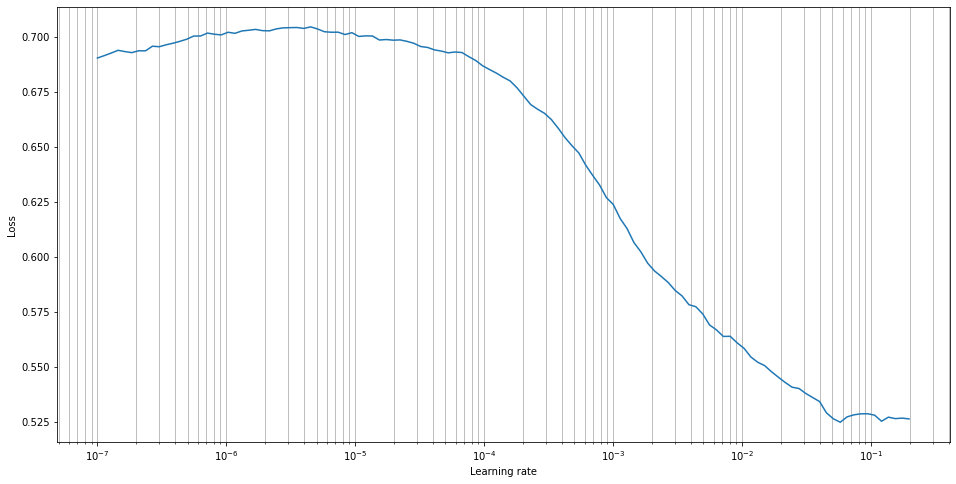

In [28]:
if Config.use_lr_finder:
    plot_lr_finder(lrs[:-18], losses[:-18])

## Trainer

In [29]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        scheduler,
        valid_labels,
        best_valid_score,
        fold,
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.best_valid_score = best_valid_score
        self.valid_labels = valid_labels
        self.fold = fold

    
    def fit(self, epochs, train_loader, valid_loader, save_path): 
        train_losses = []
        valid_losses = []
#         global N_EPOCH_EXPLICIT  #tbs later
        for n_epoch in range(epochs):
            start_time = time.time()
            print('Epoch: ', n_epoch)
            N_EPOCH_EXPLICIT = n_epoch
            train_loss, train_preds = self.train_epoch(train_loader)
            valid_loss, valid_preds = self.valid_epoch(valid_loader)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(valid_loss)
            valid_score = get_score(self.valid_labels, valid_preds)

            numbers = valid_score
            filename = Config.model_output_folder+f'score_epoch_{n_epoch}.json'          
            with open(filename, 'w') as file_object: 
                json.dump(numbers, file_object) 
            

            if self.best_valid_score < valid_score:
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path+f'best_model.pth', train_preds, valid_preds)

            print('train_loss: ',train_loss)
            print('valid_loss: ',valid_loss)
            print('valid_score: ',valid_score)
            print('best_valid_score: ',self.best_valid_score)
            print('time used: ', time.time()-start_time)

            wandb.log({f"[fold{self.fold}] epoch": n_epoch+1, 
                      f"[fold{self.fold}] avg_train_loss": train_loss, 
                      f"[fold{self.fold}] avg_val_loss": valid_loss,
                      f"[fold{self.fold}] val_score": valid_score})        

        # fig,ax = plt.subplots(1,1,figsize=(15,7))
        # ax.plot(list(range(epochs)), train_losses, label="train_loss")
        # ax.plot(list(range(epochs)), valid_losses, label="val_loss")
        # fig.legend()
        # plt.show()            
            
    def train_epoch(self, train_loader):
        if Config.amp:
            scaler = GradScaler()
        self.model.train()
        losses = []
        train_loss = 0
        # preds = []
        for step, batch in enumerate(train_loader, 1):
            self.optimizer.zero_grad()
            X = batch[0].to(self.device,non_blocking=Config.non_blocking)
            targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
            
            if Config.use_mixup:
                (X_mix, targets_a, targets_b, lam) = mixup_data(
                    X, targets, Config.mixup_alpha
                )
                with autocast(enabled=False):
                    outputs = self.model(X_mix).squeeze()
                    loss = mixed_criterion(self.criterion, outputs, targets_a, targets_b, lam)
            else:
                with autocast(enabled=False):
                    outputs = self.model(X).squeeze()
                    loss = self.criterion(outputs, targets)

                
            if Config.gradient_accumulation_steps > 1:
                loss = loss / Config.gradient_accumulation_steps
            scaler.scale(loss).backward()
          
            if (step) % Config.gradient_accumulation_steps == 0:
                scaler.step(self.optimizer)
                scaler.update()
            

            if (not isinstance(self.scheduler, ReduceLROnPlateau)):
                self.scheduler.step()

            # preds.append(outputs.sigmoid().to('cpu').detach().numpy())
            loss2 = loss.detach()

            wandb.log({f"[fold{self.fold}] loss": loss2,
                       f"[fold{self.fold}] lr": self.scheduler.get_last_lr()[0]})            

            # losses.append(loss2.item())
            losses.append(loss2)
            train_loss += loss2

            if (step) % Config.print_num_steps == 0:
                train_loss = train_loss.item() #synch once per print_num_steps instead of once per batch
                print(f'[{step}/{len(train_loader)}] ', 
                      f'avg loss: ',train_loss/step,
                      f'inst loss: ', loss2.item())
                
        # predictions = np.concatenate(preds)

#         losses_avg = []
#         for i, loss in enumerate(losses):
#             if i == 0 :
#                 losses_avg.append(loss)
#             else:
#                 losses_avg.append(losses_avg[-1] * 0.6 + loss * 0.4)
#         losses = torch.stack(losses)
#         losses_avg = torch.stack(losses_avg)
#         fig,ax = plt.subplots(1,1,figsize=(15,7))
#         ax.plot(list(range(step)), losses, label="train_loss per step")
#         ax.plot(list(range(step)), losses_avg, label="train_loss_avg per step")
#         fig.legend()
#         plt.show()            
        
        return train_loss / step, None#, predictions

    def valid_epoch(self, valid_loader):
        self.model.eval()      
        valid_loss = []
        preds = []
        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch[0].to(self.device,non_blocking=Config.non_blocking)
                targets = batch[1].to(self.device,non_blocking=Config.non_blocking)
                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, targets)
                if Config.gradient_accumulation_steps > 1:
                    loss = loss / Config.gradient_accumulation_steps
                valid_loss.append(loss.detach().item())
                preds.append(outputs.sigmoid().to('cpu').numpy())
#                 valid_loss.append(loss.detach())#.item())
#                 preds.append(outputs.sigmoid())#.to('cpu').numpy())
#         valid_loss = torch.cat(valid_loss).to('cpu').numpy()
#         predictions = torch.cat(preds).to('cpu').numpy()
        predictions = np.concatenate(preds)
        return np.mean(valid_loss), predictions

    def save_model(self, n_epoch, save_path, train_preds, valid_preds):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
                'scheduler': self.scheduler.state_dict(),
                'train_preds': train_preds,
                'valid_preds': valid_preds,
            },
            save_path,
        )
    


# Training loop

In [30]:
seed_torch(seed=Config.seed)

In [31]:
# def check_PL(fold):
#     up_thresh = Config.up_thresh
#     down_thresh = Config.down_thresh
#     pseudo_label_df = pd.read_csv(Config.pseudo_label_folder + f"test_Fold_{fold}.csv") 
#     pseudo_label_df.head()
#     pseudo_label_df["target"] = pseudo_label_df[f'preds_Fold_{fold}']#or adding tta
#     num_test = pseudo_label_df.shape[0]
#     num_yes = (pseudo_label_df["target"] >= up_thresh).sum()
#     num_no = (pseudo_label_df["target"] <= down_thresh).sum()
#     num_all = num_yes+num_no
#     print("{:.2%} ratio, {:.2%} 1, {:.2%} 0".format(num_all/num_test, num_yes/num_test, num_no/num_test))
#     print(num_all)

In [32]:
# if Config.use_pseudo_label:
#     for fold in Config.train_folds:
#         check_PL(fold)

## non-leaky PL

In [33]:
def generate_PL(fold,up_thresh,down_thresh,train_df,test_df):
    pseudo_label_df = pd.read_csv(Config.pseudo_label_folder + f"test_Fold_{fold}.csv") 
    
    #soft labels
    pseudo_label_df["target"] = pseudo_label_df[f'preds_Fold_{fold}']
    
    #harden labels
#     test_df_2 = pseudo_label_df[(pseudo_label_df["target"] >= up_thresh) | (pseudo_label_df["target"] <= down_thresh)].copy()
#     test_df_2["target"] = (test_df_2["target"] >= up_thresh).astype(int)
#     test_df_2 = test_df_2.merge(test_df[["id","file_path"]],on="id",how="left") #no need for this line if already has path
    test_df_2 = pseudo_label_df.copy()
    test_df_2['fold'] = Config.n_fold
    PL_train_df = pd.concat([train_df, test_df_2]).reset_index(drop=True)
    PL_train_df.reset_index(inplace=True, drop=True)
#         display(train_df_PL.groupby('fold')['target'].apply(lambda s: s.value_counts(normalize=True)))
#         display(train_df_PL.shape)
#         display(train_df_PL)
    return PL_train_df

In [34]:
#generate_PL(fold,Config.up_thresh,Config.down_thresh,train_df.copy(),test_df) 

In [35]:
def training_loop(train_df, use_checkpoint=Config.use_checkpoint):
    kf = StratifiedKFold(n_splits=Config.n_fold, shuffle=True, random_state=Config.seed)
    avg_best_valid_score = 0
    folds_val_score = []
    original_train_df = train_df.copy()#for PL
    for fold in range(Config.n_fold): 
        if Config.use_pseudo_label:
            PL_train_df = generate_PL(fold,Config.up_thresh,Config.down_thresh,original_train_df.copy(),test_df)   
            train_df = PL_train_df
        train_index, valid_index = train_df.query(f"fold!={fold}").index, train_df.query(f"fold=={fold}").index #fold means fold_valid 
        print('Fold: ', fold)
        if fold not in Config.train_folds:
            print("skip")
            continue
        train_X, valid_X = train_df.loc[train_index], train_df.loc[valid_index]
        valid_labels = train_df.loc[valid_index,Config.target_col].values
#         fold_indices = pd.read_csv(f'{Config.gdrive}/Fold_{fold}_indices.csv')#saved fold ids
        oof = pd.DataFrame()
        oof['id'] = train_df.loc[valid_index,'id']
        oof['id'] = valid_X['id'].values.copy()
        oof = oof.reset_index()
        # assert oof['id'].eq(fold_indices['id']).all()
#         if not Config.use_subset:
#             assert oof['id'].eq(fold_indices['id']).sum()==112000
        oof['target'] = valid_labels
        
        oof.to_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv')
        # continue # uncomment this is to check oof ids

        print('training data samples, val data samples: ', len(train_X) ,len(valid_X))
        train_data_retriever = DataRetriever(train_X["file_path"].values, train_X["target"].values, transforms=train_transform)#how to run this only once and use for next experiment?
        valid_data_retriever = DataRetrieverTest(valid_X["file_path"].values, valid_X["target"].values, transforms=test_transform)        
        train_loader = DataLoader(train_data_retriever,
                                  batch_size=Config.batch_size, 
                                  shuffle=True, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)
        valid_loader = DataLoader(valid_data_retriever, 
                                  batch_size=Config.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=Config.num_workers, pin_memory=True, drop_last=False)

        model = Model()
        model.to(device,non_blocking=Config.non_blocking)
        optimizer = AdamW(model.parameters(), lr=Config.lr,eps=1e-04, weight_decay=Config.weight_decay, amsgrad=False) #eps to avoid NaN/Inf in training loss
        scheduler = get_scheduler(optimizer, len(train_X))
        best_valid_score = -np.inf
        if use_checkpoint:
            print("Load Checkpoint, epo")
            checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_valid_score = float(checkpoint['best_valid_score'])
            scheduler.load_state_dict(checkpoint['scheduler'])
        
        
        criterion = torch_functional.binary_cross_entropy_with_logits
        

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion,
            scheduler,
            valid_labels,
            best_valid_score,
            fold
        )

        history = trainer.fit(
            epochs=Config.epochs, 
            train_loader=train_loader, 
            valid_loader=valid_loader,
            save_path=f'{Config.model_output_folder}/Fold_{fold}_',
        )
        folds_val_score.append(trainer.best_valid_score)
        del train_data_retriever
    wandb.finish()
    print('folds score:', folds_val_score)
    print("Avg: {:.5f}".format(np.mean(folds_val_score)))
    print("Std: {:.5f}".format(np.std(folds_val_score)))
    

# Weight & Bias Initialization

In [36]:
wandb.login(key="1b0833b15e81d54fad9cfbbe3d923f57562a6f89")

wandb: Currently logged in as: kaggle_go (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/.netrc


True

In [37]:
job_type= "debug" if Config.debug else "train"
# run = wandb.init(project="G2Net", name=Config.model_version, config=class2dict(Config), group=Config.model_name, job_type=job_type)
run = wandb.init(project="G2Net", name=Config.model_version, config=class2dict(Config), group=Config.model_name, job_type=Config.model_version)


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# Train

In [38]:
%%time
try:
#     %lprun -f DataRetriever.__getitem__ -f Trainer.train_epoch -f Trainer.fit -f Trainer.valid_epoch training_loop() 
    training_loop(train_df,Config.use_checkpoint)
except RuntimeError as e:
    gc.collect()
    torch.cuda.empty_cache()   
    print(e)# saving oof predictions

Fold:  0
training data samples, val data samples:  674000 112000
ModelIafossV2
Epoch:  0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.5003572736467634 inst loss:  0.3867655098438263
[700/2633]  avg loss:  0.46284493582589287 inst loss:  0.4021603763103485
[1050/2633]  avg loss:  0.44633480980282736 inst loss:  0.39791756868362427
[1400/2633]  avg loss:  0.43650111607142855 inst loss:  0.4234142303466797
[1750/2633]  avg loss:  0.42990244838169644 inst loss:  0.3675483465194702
[2100/2633]  avg loss:  0.4246531749906994 inst loss:  0.3821924924850464
[2450/2633]  avg loss:  0.4208280353156888 inst loss:  0.40816813707351685


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.4192, device='cuda:0')
valid_loss:  0.4210255884960906
valid_score:  0.8726379921993132
best_valid_score:  0.8726379921993132
time used:  555.6921803951263
Epoch:  1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3915500749860491 inst loss:  0.40063267946243286
[700/2633]  avg loss:  0.3910455758231027 inst loss:  0.3839007019996643
[1050/2633]  avg loss:  0.3899938092912946 inst loss:  0.39141494035720825
[1400/2633]  avg loss:  0.38938995361328127 inst loss:  0.3739362359046936
[1750/2633]  avg loss:  0.38967229352678573 inst loss:  0.4345611333847046
[2100/2633]  avg loss:  0.3891989571707589 inst loss:  0.3616589903831482
[2450/2633]  avg loss:  0.38900206273915816 inst loss:  0.364124596118927


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3889, device='cuda:0')
valid_loss:  0.4072287877400716
valid_score:  0.877717749053788
best_valid_score:  0.877717749053788
time used:  551.9084038734436
Epoch:  2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3835544695172991 inst loss:  0.41967469453811646
[700/2633]  avg loss:  0.3832276262555804 inst loss:  0.3853771388530731
[1050/2633]  avg loss:  0.38184517996651784 inst loss:  0.33456578850746155
[1400/2633]  avg loss:  0.3816934640066964 inst loss:  0.33687546849250793
[1750/2633]  avg loss:  0.38211056082589284 inst loss:  0.4150581955909729
[2100/2633]  avg loss:  0.38181876046316965 inst loss:  0.38667622208595276
[2450/2633]  avg loss:  0.3820782346141582 inst loss:  0.3668712079524994


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3818, device='cuda:0')
valid_loss:  0.41970706190148444
valid_score:  0.8782191559728809
best_valid_score:  0.8782191559728809
time used:  551.9757137298584
Epoch:  3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3770186070033482 inst loss:  0.32136213779449463
[700/2633]  avg loss:  0.376459481375558 inst loss:  0.3548157811164856
[1050/2633]  avg loss:  0.3765399460565476 inst loss:  0.4043453335762024
[1400/2633]  avg loss:  0.37698272705078123 inst loss:  0.35492783784866333
[1750/2633]  avg loss:  0.37637649972098214 inst loss:  0.36927664279937744
[2100/2633]  avg loss:  0.375896490187872 inst loss:  0.3647564947605133
[2450/2633]  avg loss:  0.3756258221061862 inst loss:  0.3936469554901123


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3756, device='cuda:0')
valid_loss:  0.39936323239378735
valid_score:  0.8805719918979944
best_valid_score:  0.8805719918979944
time used:  551.9347636699677
Epoch:  4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3707480294363839 inst loss:  0.38554972410202026
[700/2633]  avg loss:  0.3718447004045759 inst loss:  0.41254034638404846
[1050/2633]  avg loss:  0.37057471865699404 inst loss:  0.40058332681655884
[1400/2633]  avg loss:  0.37071602957589284 inst loss:  0.37858814001083374
[1750/2633]  avg loss:  0.3707045200892857 inst loss:  0.3524106442928314
[2100/2633]  avg loss:  0.3706926037016369 inst loss:  0.38949307799339294
[2450/2633]  avg loss:  0.37049396125637757 inst loss:  0.375670850276947


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3703, device='cuda:0')
valid_loss:  0.4090315822052629
valid_score:  0.8812905609798948
best_valid_score:  0.8812905609798948
time used:  551.5274102687836
Epoch:  5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3664559064592634 inst loss:  0.35711562633514404
[700/2633]  avg loss:  0.36617793491908485 inst loss:  0.3314417600631714
[1050/2633]  avg loss:  0.36582754952566965 inst loss:  0.4140022397041321
[1400/2633]  avg loss:  0.36547326224190846 inst loss:  0.3363601565361023
[1750/2633]  avg loss:  0.36611356026785713 inst loss:  0.34666863083839417
[2100/2633]  avg loss:  0.36613871256510416 inst loss:  0.38644540309906006
[2450/2633]  avg loss:  0.36595237264827807 inst loss:  0.3590589165687561


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3661, device='cuda:0')
valid_loss:  0.4188992764851818
valid_score:  0.8813972652276353
best_valid_score:  0.8813972652276353
time used:  551.6686499118805
Fold:  1
training data samples, val data samples:  674000 112000
ModelIafossV2
Epoch:  0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.5008421543666295 inst loss:  0.4362630248069763
[700/2633]  avg loss:  0.4611658150809152 inst loss:  0.40896642208099365
[1050/2633]  avg loss:  0.4445051792689732 inst loss:  0.40314722061157227
[1400/2633]  avg loss:  0.433914315359933 inst loss:  0.3973780572414398
[1750/2633]  avg loss:  0.42751143973214284 inst loss:  0.447491854429245
[2100/2633]  avg loss:  0.42189482189360117 inst loss:  0.37994492053985596
[2450/2633]  avg loss:  0.41788434709821426 inst loss:  0.3529663681983948


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.4160, device='cuda:0')
valid_loss:  0.4304323652291407
valid_score:  0.8717763291990308
best_valid_score:  0.8717763291990308
time used:  551.9198005199432
Epoch:  1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.39001469203404016 inst loss:  0.42764195799827576
[700/2633]  avg loss:  0.3878819056919643 inst loss:  0.3941894769668579
[1050/2633]  avg loss:  0.3870373825799851 inst loss:  0.37149572372436523
[1400/2633]  avg loss:  0.38661433628627234 inst loss:  0.38721713423728943
[1750/2633]  avg loss:  0.38637949916294645 inst loss:  0.42434296011924744
[2100/2633]  avg loss:  0.3859879847935268 inst loss:  0.3697793781757355
[2450/2633]  avg loss:  0.3857521524234694 inst loss:  0.37732404470443726


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3855, device='cuda:0')
valid_loss:  0.42271281744791495
valid_score:  0.8755655681157052
best_valid_score:  0.8755655681157052
time used:  551.8290421962738
Epoch:  2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3769676862444196 inst loss:  0.3692851960659027
[700/2633]  avg loss:  0.3794281877790179 inst loss:  0.34652501344680786
[1050/2633]  avg loss:  0.37930914015997025 inst loss:  0.3981020450592041
[1400/2633]  avg loss:  0.37918116978236605 inst loss:  0.3789381980895996
[1750/2633]  avg loss:  0.37890053013392855 inst loss:  0.41765761375427246
[2100/2633]  avg loss:  0.37893330891927085 inst loss:  0.37240177392959595
[2450/2633]  avg loss:  0.3790084153778699 inst loss:  0.41850441694259644


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3789, device='cuda:0')
valid_loss:  0.41091725393517375
valid_score:  0.8780997100151605
best_valid_score:  0.8780997100151605
time used:  551.9366595745087
Epoch:  3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3741966029575893 inst loss:  0.3893216848373413
[700/2633]  avg loss:  0.37417977469308034 inst loss:  0.37590712308883667
[1050/2633]  avg loss:  0.37366678873697917 inst loss:  0.35213667154312134
[1400/2633]  avg loss:  0.37305511474609376 inst loss:  0.37422770261764526
[1750/2633]  avg loss:  0.3729835030691964 inst loss:  0.39322662353515625
[2100/2633]  avg loss:  0.3729292515345982 inst loss:  0.3615248501300812
[2450/2633]  avg loss:  0.37311782525510206 inst loss:  0.36144834756851196


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3730, device='cuda:0')
valid_loss:  0.40574361118551805
valid_score:  0.8797872727800718
best_valid_score:  0.8797872727800718
time used:  551.903558254242
Epoch:  4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.36708657400948663 inst loss:  0.3822900056838989
[700/2633]  avg loss:  0.367993643624442 inst loss:  0.4197021722793579
[1050/2633]  avg loss:  0.36853838239397324 inst loss:  0.4079897999763489
[1400/2633]  avg loss:  0.36815992082868304 inst loss:  0.34302210807800293
[1750/2633]  avg loss:  0.36776708984375 inst loss:  0.3374071717262268
[2100/2633]  avg loss:  0.36754586356026786 inst loss:  0.36652278900146484
[2450/2633]  avg loss:  0.3676153938137755 inst loss:  0.36171936988830566


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3678, device='cuda:0')
valid_loss:  0.4177906952764346
valid_score:  0.8798625478166644
best_valid_score:  0.8798625478166644
time used:  551.7076375484467
Epoch:  5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.36376085553850446 inst loss:  0.35493358969688416
[700/2633]  avg loss:  0.36294767107282366 inst loss:  0.37041395902633667
[1050/2633]  avg loss:  0.3633499581473214 inst loss:  0.3282294273376465
[1400/2633]  avg loss:  0.3639602225167411 inst loss:  0.31495606899261475
[1750/2633]  avg loss:  0.3640554896763393 inst loss:  0.36666715145111084
[2100/2633]  avg loss:  0.36399512881324403 inst loss:  0.35110026597976685
[2450/2633]  avg loss:  0.3637737663424745 inst loss:  0.32748928666114807


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3638, device='cuda:0')
valid_loss:  0.4183265915200046
valid_score:  0.8801770258337681
best_valid_score:  0.8801770258337681
time used:  551.8627302646637
Fold:  2
training data samples, val data samples:  674000 112000
ModelIafossV2
Epoch:  0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.5009562901088169 inst loss:  0.4281560182571411
[700/2633]  avg loss:  0.46416285923549105 inst loss:  0.3850356638431549
[1050/2633]  avg loss:  0.44866725376674105 inst loss:  0.39652740955352783
[1400/2633]  avg loss:  0.43864946637834823 inst loss:  0.3731676936149597
[1750/2633]  avg loss:  0.4321004813058036 inst loss:  0.43238964676856995
[2100/2633]  avg loss:  0.4267306954520089 inst loss:  0.3767877221107483
[2450/2633]  avg loss:  0.42243986168686226 inst loss:  0.42954570055007935


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.4205, device='cuda:0')
valid_loss:  0.41036402675659145
valid_score:  0.8726640899369138
best_valid_score:  0.8726640899369138
time used:  551.7233927249908
Epoch:  1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.39173025948660717 inst loss:  0.4278798997402191
[700/2633]  avg loss:  0.3903182111467634 inst loss:  0.38231784105300903
[1050/2633]  avg loss:  0.39004972912016367 inst loss:  0.38689467310905457
[1400/2633]  avg loss:  0.38889007568359374 inst loss:  0.3615129590034485
[1750/2633]  avg loss:  0.3884808872767857 inst loss:  0.46252351999282837
[2100/2633]  avg loss:  0.38827831449962796 inst loss:  0.4021753668785095
[2450/2633]  avg loss:  0.38818730568399235 inst loss:  0.40438705682754517


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3882, device='cuda:0')
valid_loss:  0.4271347192052293
valid_score:  0.8761379772713787
best_valid_score:  0.8761379772713787
time used:  551.9645791053772
Epoch:  2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.38340868268694195 inst loss:  0.37794455885887146
[700/2633]  avg loss:  0.38157906668526786 inst loss:  0.3909333050251007
[1050/2633]  avg loss:  0.38169628324962795 inst loss:  0.4115670621395111
[1400/2633]  avg loss:  0.3814861624581473 inst loss:  0.38982653617858887
[1750/2633]  avg loss:  0.380893310546875 inst loss:  0.3455107808113098
[2100/2633]  avg loss:  0.3809172712053571 inst loss:  0.4252614974975586
[2450/2633]  avg loss:  0.3804091348453444 inst loss:  0.36253058910369873


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3807, device='cuda:0')
valid_loss:  0.41090325174266346
valid_score:  0.8785511362232216
best_valid_score:  0.8785511362232216
time used:  551.7301068305969
Epoch:  3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3774117170061384 inst loss:  0.3745355010032654
[700/2633]  avg loss:  0.3761586216517857 inst loss:  0.38149741291999817
[1050/2633]  avg loss:  0.3756930687313988 inst loss:  0.36314475536346436
[1400/2633]  avg loss:  0.37542149135044645 inst loss:  0.32907742261886597
[1750/2633]  avg loss:  0.37511962890625 inst loss:  0.4269590973854065
[2100/2633]  avg loss:  0.3748561314174107 inst loss:  0.386328786611557
[2450/2633]  avg loss:  0.3748662209024235 inst loss:  0.36362236738204956


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3749, device='cuda:0')
valid_loss:  0.40826823803932155
valid_score:  0.8798033973027634
best_valid_score:  0.8798033973027634
time used:  551.8555850982666
Epoch:  4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3681913103376116 inst loss:  0.34383177757263184
[700/2633]  avg loss:  0.36831063406808034 inst loss:  0.3717655539512634
[1050/2633]  avg loss:  0.36968392508370534 inst loss:  0.37861308455467224
[1400/2633]  avg loss:  0.3696057564871652 inst loss:  0.394997775554657
[1750/2633]  avg loss:  0.3696788853236607 inst loss:  0.34438958764076233
[2100/2633]  avg loss:  0.36949640183221727 inst loss:  0.3540642261505127
[2450/2633]  avg loss:  0.3693297343351403 inst loss:  0.33006054162979126


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3691, device='cuda:0')
valid_loss:  0.4437042105959975
valid_score:  0.8799002882526966
best_valid_score:  0.8799002882526966
time used:  551.951996088028
Epoch:  5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.363199462890625 inst loss:  0.3259555697441101
[700/2633]  avg loss:  0.3640176391601562 inst loss:  0.36516469717025757
[1050/2633]  avg loss:  0.36455278669084823 inst loss:  0.37630006670951843
[1400/2633]  avg loss:  0.3650522286551339 inst loss:  0.41254594922065735
[1750/2633]  avg loss:  0.365106689453125 inst loss:  0.4395408630371094
[2100/2633]  avg loss:  0.3650131370907738 inst loss:  0.3566322326660156
[2450/2633]  avg loss:  0.36490757533482143 inst loss:  0.3636917471885681


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3648, device='cuda:0')
valid_loss:  0.4084599493028911
valid_score:  0.880162177937432
best_valid_score:  0.880162177937432
time used:  551.6552650928497
Fold:  3
training data samples, val data samples:  674000 112000
ModelIafossV2
Epoch:  0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.4991909354073661 inst loss:  0.39968013763427734
[700/2633]  avg loss:  0.46090305873325893 inst loss:  0.39155441522598267
[1050/2633]  avg loss:  0.444290771484375 inst loss:  0.3797740936279297
[1400/2633]  avg loss:  0.433947274344308 inst loss:  0.39508670568466187
[1750/2633]  avg loss:  0.42779031808035717 inst loss:  0.4130452871322632
[2100/2633]  avg loss:  0.42283961704799106 inst loss:  0.32450687885284424
[2450/2633]  avg loss:  0.41860157246492347 inst loss:  0.3833997845649719


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.4171, device='cuda:0')
valid_loss:  0.44282456116589236
valid_score:  0.8740166309972129
best_valid_score:  0.8740166309972129
time used:  551.7601633071899
Epoch:  1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3894011579241071 inst loss:  0.41626235842704773
[700/2633]  avg loss:  0.3877301025390625 inst loss:  0.36799368262290955
[1050/2633]  avg loss:  0.3882068161737351 inst loss:  0.3609442412853241
[1400/2633]  avg loss:  0.38767163957868306 inst loss:  0.36396634578704834
[1750/2633]  avg loss:  0.3870615234375 inst loss:  0.36946234107017517
[2100/2633]  avg loss:  0.38658354259672617 inst loss:  0.3926631212234497
[2450/2633]  avg loss:  0.3861304956552934 inst loss:  0.35711199045181274


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3862, device='cuda:0')
valid_loss:  0.405308982961254
valid_score:  0.876700425329491
best_valid_score:  0.876700425329491
time used:  551.8385701179504
Epoch:  2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.38006282261439733 inst loss:  0.42001470923423767
[700/2633]  avg loss:  0.3802676827566964 inst loss:  0.37239861488342285
[1050/2633]  avg loss:  0.38003409249441966 inst loss:  0.38411951065063477
[1400/2633]  avg loss:  0.37981087820870535 inst loss:  0.4186553955078125
[1750/2633]  avg loss:  0.37978585379464286 inst loss:  0.3850126266479492
[2100/2633]  avg loss:  0.37989141555059525 inst loss:  0.35987555980682373
[2450/2633]  avg loss:  0.37978126992984695 inst loss:  0.35233598947525024


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3796, device='cuda:0')
valid_loss:  0.4047781712116172
valid_score:  0.8788436810438015
best_valid_score:  0.8788436810438015
time used:  551.6220486164093
Epoch:  3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.37524758475167413 inst loss:  0.42510291934013367
[700/2633]  avg loss:  0.37477308000837056 inst loss:  0.34067875146865845
[1050/2633]  avg loss:  0.37430274600074404 inst loss:  0.3184123635292053
[1400/2633]  avg loss:  0.37450469970703126 inst loss:  0.3617323040962219
[1750/2633]  avg loss:  0.37465638950892854 inst loss:  0.35331130027770996
[2100/2633]  avg loss:  0.3742342122395833 inst loss:  0.3563998341560364
[2450/2633]  avg loss:  0.3737203294403699 inst loss:  0.3965831696987152


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3737, device='cuda:0')
valid_loss:  0.3996483856412374
valid_score:  0.8813569669151676
best_valid_score:  0.8813569669151676
time used:  551.7905442714691
Epoch:  4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.36651123046875 inst loss:  0.3820420503616333
[700/2633]  avg loss:  0.36864632742745534 inst loss:  0.35858261585235596
[1050/2633]  avg loss:  0.3677800060453869 inst loss:  0.3708727955818176
[1400/2633]  avg loss:  0.36713535853794643 inst loss:  0.3744082450866699
[1750/2633]  avg loss:  0.3674744349888393 inst loss:  0.406375527381897
[2100/2633]  avg loss:  0.3679822067987351 inst loss:  0.38409942388534546
[2450/2633]  avg loss:  0.3681454779177296 inst loss:  0.3629993796348572


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3682, device='cuda:0')
valid_loss:  0.41204402776069293
valid_score:  0.8815293331568078
best_valid_score:  0.8815293331568078
time used:  552.2707071304321
Epoch:  5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3659344046456473 inst loss:  0.4010641574859619
[700/2633]  avg loss:  0.3650195094517299 inst loss:  0.32591596245765686
[1050/2633]  avg loss:  0.36440528506324404 inst loss:  0.37887319922447205
[1400/2633]  avg loss:  0.364428231375558 inst loss:  0.3611024022102356
[1750/2633]  avg loss:  0.36436226981026787 inst loss:  0.33173203468322754
[2100/2633]  avg loss:  0.3643360828218006 inst loss:  0.34491151571273804
[2450/2633]  avg loss:  0.3643210399394133 inst loss:  0.40423670411109924


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3641, device='cuda:0')
valid_loss:  0.4056899685021405
valid_score:  0.8814289952997715
best_valid_score:  0.8815293331568078
time used:  552.1954417228699
Fold:  4
training data samples, val data samples:  674000 112000
ModelIafossV2
Epoch:  0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.5024041312081473 inst loss:  0.45513904094696045
[700/2633]  avg loss:  0.4675147356305804 inst loss:  0.3932739496231079
[1050/2633]  avg loss:  0.4518134416852679 inst loss:  0.4255344271659851
[1400/2633]  avg loss:  0.44241707938058034 inst loss:  0.3973941206932068
[1750/2633]  avg loss:  0.43538295200892857 inst loss:  0.38236677646636963
[2100/2633]  avg loss:  0.43014488583519345 inst loss:  0.4166404604911804
[2450/2633]  avg loss:  0.42638338050063773 inst loss:  0.3421199917793274


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.4250, device='cuda:0')
valid_loss:  0.41434986773691224
valid_score:  0.8726566511609386
best_valid_score:  0.8726566511609386
time used:  552.3950870037079
Epoch:  1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.39652321951729913 inst loss:  0.3531532883644104
[700/2633]  avg loss:  0.39613006591796873 inst loss:  0.41478291153907776
[1050/2633]  avg loss:  0.3963590785435268 inst loss:  0.36504971981048584
[1400/2633]  avg loss:  0.3960298810686384 inst loss:  0.41520994901657104
[1750/2633]  avg loss:  0.3958601771763393 inst loss:  0.3526204526424408
[2100/2633]  avg loss:  0.3952843075706845 inst loss:  0.35186877846717834
[2450/2633]  avg loss:  0.39477152921715564 inst loss:  0.3801906704902649


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3944, device='cuda:0')
valid_loss:  0.412165055127993
valid_score:  0.8761281174174461
best_valid_score:  0.8761281174174461
time used:  552.4149925708771
Epoch:  2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3892323521205357 inst loss:  0.42084813117980957
[700/2633]  avg loss:  0.38807525634765627 inst loss:  0.38841745257377625
[1050/2633]  avg loss:  0.38841817220052083 inst loss:  0.38143402338027954
[1400/2633]  avg loss:  0.3884298270089286 inst loss:  0.3873397409915924
[1750/2633]  avg loss:  0.38800599888392856 inst loss:  0.39924389123916626
[2100/2633]  avg loss:  0.387843017578125 inst loss:  0.36507105827331543
[2450/2633]  avg loss:  0.38735147281568877 inst loss:  0.35237860679626465


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3872, device='cuda:0')
valid_loss:  0.4081032805519017
valid_score:  0.8786730332333912
best_valid_score:  0.8786730332333912
time used:  552.6156754493713
Epoch:  3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.382769034249442 inst loss:  0.4073895215988159
[700/2633]  avg loss:  0.3828741455078125 inst loss:  0.3565487265586853
[1050/2633]  avg loss:  0.38218302408854166 inst loss:  0.38404226303100586
[1400/2633]  avg loss:  0.38150020054408484 inst loss:  0.3558756709098816
[1750/2633]  avg loss:  0.38183586774553574 inst loss:  0.40900176763534546
[2100/2633]  avg loss:  0.3816589064825149 inst loss:  0.3590885400772095
[2450/2633]  avg loss:  0.3815655642139668 inst loss:  0.3549858331680298


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3812, device='cuda:0')
valid_loss:  0.44296999854039926
valid_score:  0.8795349505385365
best_valid_score:  0.8795349505385365
time used:  552.5400593280792
Epoch:  4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3759337071010045 inst loss:  0.4100154638290405
[700/2633]  avg loss:  0.37581272670200894 inst loss:  0.3749558925628662
[1050/2633]  avg loss:  0.3757036481584821 inst loss:  0.41346973180770874
[1400/2633]  avg loss:  0.37567108154296874 inst loss:  0.32801568508148193
[1750/2633]  avg loss:  0.3761580636160714 inst loss:  0.3752742111682892
[2100/2633]  avg loss:  0.37574180966331844 inst loss:  0.3221029043197632
[2450/2633]  avg loss:  0.37544747488839286 inst loss:  0.3803778290748596


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3756, device='cuda:0')
valid_loss:  0.4010704608812724
valid_score:  0.8800290792365113
best_valid_score:  0.8800290792365113
time used:  552.5239539146423
Epoch:  5


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[350/2633]  avg loss:  0.3716849626813616 inst loss:  0.4024779200553894
[700/2633]  avg loss:  0.37182124546595985 inst loss:  0.3824573755264282
[1050/2633]  avg loss:  0.3717970493861607 inst loss:  0.44455885887145996
[1400/2633]  avg loss:  0.37132886614118304 inst loss:  0.43574798107147217
[1750/2633]  avg loss:  0.37165182059151786 inst loss:  0.40014737844467163
[2100/2633]  avg loss:  0.3716146995907738 inst loss:  0.3725897967815399
[2450/2633]  avg loss:  0.37159974390146683 inst loss:  0.36302995681762695


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train_loss:  tensor(0.3713, device='cuda:0')
valid_loss:  0.4042333847583701
valid_score:  0.8801151519459725
best_valid_score:  0.8801151519459725
time used:  552.6496922969818


[fold0] avg_train_loss,0.36611
[fold0] avg_val_loss,0.4189
[fold0] epoch,6
[fold0] loss,0.29943
[fold0] lr,0.0
[fold0] val_score,0.8814
[fold1] avg_train_loss,0.36382
[fold1] avg_val_loss,0.41833
[fold1] epoch,6
[fold1] loss,0.31995
[fold1] lr,0.0


[fold0] avg_train_loss,█▄▃▂▂▁
[fold0] avg_val_loss,█▄█▁▄▇
[fold0] epoch,▁▂▄▅▇█
[fold0] loss,█▄▆▆▄▄▃▆▄▂█▂▅▃▄▅▅▆▅▄▂▄▅▅▃▃▄▃▃▃▂▄▁▅▃▃▂▁▁▅
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold0] val_score,▁▅▅▇██
[fold1] avg_train_loss,█▄▃▂▂▁
[fold1] avg_val_loss,█▆▂▁▄▅
[fold1] epoch,▁▂▄▅▇█
[fold1] loss,█▇▄▃▃▃▁▆▄▅▄▄▂▄▅▃▄▂▃▄▄▃▂▄▃▃▃▄▂▁▁▃▄▁▃▃▃▄▂▂
[fold1] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


folds score: [0.8813972652276353, 0.8801770258337681, 0.880162177937432, 0.8815293331568078, 0.8801151519459725]
Avg: 0.88068
Std: 0.00064
CPU times: user 4h 24min 8s, sys: 20min 19s, total: 4h 44min 27s
Wall time: 4h 36min 13s


In [39]:
pass

# Pause

In [40]:
print(Config.train_folds)

[0, 1, 2, 3, 4]


In [41]:
# %%javascript
# import Ipython
# IPython.notebook.save_notebook()

In [42]:
from time import sleep
sleep(120)

In [43]:
# from jarviscloud import jarviscloud
# jarviscloud.pause()

In [44]:
for fold in Config.train_folds:
    print(fold)
    checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
    # print(checkpoint['valid_preds'])
    try:
        # oof = pd.read_csv(f'{Config.gdrive}/Fold_{fold}_indices.csv') also works, used in replacement of next statement for previously not generated Fold_{fold}_oof_pred.csv
        oof = pd.read_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv')
        oof['pred'] = checkpoint['valid_preds']
        oof.to_csv(f'{Config.model_output_folder}/Fold_{fold}_oof_pred.csv') 
        print('successfully saved oof predictions for Fold: ', fold)   
    except:
        raise RuntimeError('failure in saving predictions for Fold: ', fold)

0
successfully saved oof predictions for Fold:  0
1
successfully saved oof predictions for Fold:  1
2
successfully saved oof predictions for Fold:  2
3
successfully saved oof predictions for Fold:  3
4
successfully saved oof predictions for Fold:  4


# add TTA

In [45]:
# dataset

In [46]:
#tbs need pythonic way
class TTA(Dataset):
    def __init__(self, paths, targets, vflip=False, shuffle_channels=False, time_shift=False, 
                 add_gaussian_noise = False,  time_stretch=False,shuffle01=False,timemask=False,
                 shift_channel=False,reduce_SNR=False, ):
        self.paths = paths
        self.targets = targets
        self.vflip = vflip
        self.shuffle_channels = shuffle_channels
        self.time_shift = time_shift
        self.add_gaussian_noise = add_gaussian_noise
        self.time_stretch = time_stretch
        self.shuffle01 = shuffle01
        self.timemask = timemask
        self.shift_channel = shift_channel
        self.reduce_SNR = reduce_SNR
        if time_shift:
            self.time_shift = A.Shift(min_fraction=-Config.time_shift_left*1.0/4096, 
                                      max_fraction=Config.time_shift_right*1.0/4096, p=1,rollover=False)
        if add_gaussian_noise:
            self.add_gaussian_noise = A.AddGaussianNoise(min_amplitude=0.001*0.015, max_amplitude= 0.015*0.015, p=1)
        if time_stretch:
            self.time_stretch = A.TimeStretch(min_rate=0.9, max_rate=1.111,leave_length_unchanged=True, p=1)
        if timemask:
            self.timemask = A.TimeMask(min_band_part=0.0, max_band_part=0.03, fade=False, p=1.0)

              
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index] 
        waves = np.load(path)

#         if Config.divide_std:
#             waves /= 0.015

        if self.vflip:
            waves = -waves
        if self.shuffle_channels:
            np.random.shuffle(waves)
        if self.time_shift:
            waves = self.time_shift(waves, sample_rate=2048)
        if self.add_gaussian_noise:
            waves = self.add_gaussian_noise(waves, sample_rate=2048)
        if self.time_stretch:
            waves = self.time_stretch(waves, sample_rate=2048)
        if self.shuffle01:
            waves[[0,1]] = waves[[1,0]]
        if self.timemask:
            waves = self.timemask(waves, sample_rate=2048)
        if self.shift_channel:
            waves = shift_channel_func(waves, sample_rate=2048)
        if self.reduce_SNR:
            waves = reduce_SNR_func(waves, sample_rate=2048)
        #snr, shift_channel tba
        
        waves = torch.from_numpy(waves) 
        target = torch.tensor(self.targets[index],dtype=torch.float)#device=device,             
        return (waves, target)

In [47]:
## functions for making predictions

In [48]:
def get_pred(loader,model):
    preds = []
    for step, batch in enumerate(loader, 1):
        if step % Config.print_num_steps == 0:
            print("step {}/{}".format(step, len(loader)))
        with torch.no_grad():
            X = batch[0].to(device,non_blocking=Config.non_blocking)
            outputs = model(X).squeeze()
            preds.append(outputs.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

def get_tta_pred(df,model,**transforms):
    data_retriever = TTA(df['file_path'].values, df['target'].values, **transforms)
    loader = DataLoader(data_retriever, 
                            batch_size=Config.batch_size * 2, 
                            shuffle=False, 
                            num_workers=Config.num_workers, pin_memory=True, drop_last=False)
    return get_pred(loader,model)

     

In [49]:
##TTA for oof
print(conserv_transform_list_strings)
print(aggressive_transform_list_strings)

[]
['vflip', 'add_gaussian_noise', 'timemask', 'shuffle01', 'time_shift']


In [50]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
conserv_transform_powerset = list(powerset(conserv_transform_list_strings))
conserv_transform_powerset

[()]

In [51]:
for transformations in conserv_transform_powerset:
    print({transformation:True for transformation in transformations})

{}


## generate oof tta

In [ ]:

model = Model()

for fold in Config.train_folds:
    print('Fold ',fold)
    oof = train_df.query(f"fold=={fold}").copy()
    oof['preds'] = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')['valid_preds']
    oof['file_path'] = train_df['id'].apply(lambda x :id_2_path(x))
    # display(oof)    

    checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device=device,non_blocking=Config.non_blocking)
    model.eval()
    
    for transformations in conserv_transform_powerset:
#         print(transformations)
        if transformations:#to avoid double count original
            print("tta_"+('_').join(transformations))
            oof["tta_"+('_').join(transformations)] = get_tta_pred(oof,model,**{transformation:True for transformation in transformations})
        for aggr_transformation in aggressive_transform_list_strings:#tbs combination of conservative and aggressive
            print("tta_"+('_').join(transformations)+'_'+aggr_transformation)
            oof["tta_"+('_').join(transformations)+'_'+aggr_transformation] = get_tta_pred(oof,model,**{transformation:True for transformation in transformations}, **{aggr_transformation:True})
               

    oof.to_csv(Config.model_output_folder + f"/oof_Fold_{fold}.csv", index=False)
    


In [53]:
oof_all = pd.DataFrame()
for fold in Config.train_folds:
    oof = pd.read_csv(Config.model_output_folder + f"/oof_Fold_{fold}.csv")
    oof_all = pd.concat([oof_all,oof])

In [54]:
# ('_').join(transformations)


In [55]:
print("Original:",roc_auc_score(oof_all['target'], oof_all['preds']))

for col in oof_all.columns:
    if "tta" in col:
        print(col,roc_auc_score(oof_all['target'], oof_all[col]))

Original: 0.8801739879573027
tta__vflip 0.8802155890695967
tta__add_gaussian_noise 0.8801488065845556
tta__timemask 0.8779151828990358
tta__shuffle01 0.8796113994017328
tta__time_shift 0.8787075903592754


In [56]:
oof_sample = oof_all[oof_all['fold']==2]
roc_auc_score(oof_sample['target'], oof_sample['preds'])

0.880162177937432

In [57]:
oof_all['avg']=0
total_weight = 0
#weights leaky? not fine tuned

oof_weight  = defaultdict(lambda :1)
aggr_total_weight = 0
for trans in aggressive_transform_list_strings:
    aggr_total_weight += getattr(Config(),trans+'_weight')

for col in oof_all.columns:
    
    if 'tta_' in col or 'preds' in col: 
        for trans in conserv_transform_list_strings:
            
            if trans in col:
                oof_weight[col] *= getattr(Config(),trans+'_proba')
            else:
                oof_weight[col] *= 1-getattr(Config(),trans+'_proba')
            
        flag = False
        for trans in aggressive_transform_list_strings:
            
            if trans in col:
                oof_weight[col] *= getattr(Config(),trans+'_weight')/aggr_total_weight*Config.aggressive_aug_proba
                
                flag = True
        if not flag:
            oof_weight[col] *= (1-Config.aggressive_aug_proba)
        
print(oof_weight)
for key,value in oof_weight.items():
    print(key,value)

for col in oof_all.columns:
    if ('tta_' in col or 'preds' in col): # and 'time_shift' not in col and 'timemask' not in col
        print(col)
        total_weight+=oof_weight[col]
        oof_all['avg'] += oof_all[col]*oof_weight[col]
oof_all['avg'] /= total_weight

print("preds_tta_avg:",roc_auc_score(oof_all['target'], oof_all['avg']))

oof_all.to_csv(Config.model_output_folder + "/oof_all.csv", index=False)
oof_all[['id','fold','avg']].rename(columns={'id':'id','fold':'fold','avg':'prediction'}).to_csv(Config.model_output_folder + "/oof_final.csv", index=False)

defaultdict(<function <lambda> at 0x7f727009f8b0>, {'preds': 0.19999999999999996, 'tta__vflip': 0.20000000000000007, 'tta__add_gaussian_noise': 0.20000000000000007, 'tta__timemask': 0.16000000000000003, 'tta__shuffle01': 0.16000000000000003, 'tta__time_shift': 0.08000000000000002})
preds 0.19999999999999996
tta__vflip 0.20000000000000007
tta__add_gaussian_noise 0.20000000000000007
tta__timemask 0.16000000000000003
tta__shuffle01 0.16000000000000003
tta__time_shift 0.08000000000000002
preds
tta__vflip
tta__add_gaussian_noise
tta__timemask
tta__shuffle01
tta__time_shift
preds_tta_avg: 0.880417961697041


## generate TTA for test

In [ ]:
%%time 
test_df['target'] = 0  
model = Model()

for fold in Config.train_folds:
    test_df2 = test_df.copy()
    checkpoint = torch.load(f'{Config.model_output_folder}/Fold_{fold}_best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device=device,non_blocking=Config.non_blocking)
    model.eval()

    test_df2['preds'+f'_Fold_{fold}'] = get_tta_pred(test_df2,model)

    for transformations in conserv_transform_powerset:
#         print(transformations)
        if transformations:#to avoid double count original
            print("tta_"+('_').join(transformations)+f'_Fold_{fold}')
            test_df2["tta_"+('_').join(transformations)+f'_Fold_{fold}'] = get_tta_pred(test_df2,model,**{transformation:True for transformation in transformations})
        for transformation in aggressive_transform_list_strings:#tbs combination of conservative and aggressive
            print("tta_"+('_').join(transformations)+'_'+transformation+f'_Fold_{fold}')
            test_df2["tta_"+('_').join(transformations)+'_'+transformation+f'_Fold_{fold}'] = get_tta_pred(test_df2,model,**{transformation:True for transformation in transformations}, **{transformation:True})
               
    test_df2.to_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv", index=False)


ModelIafossV2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__vflip_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__timemask_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__shuffle01_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_0


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__vflip_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__timemask_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__shuffle01_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__vflip_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__vflip_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__timemask_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__shuffle01_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__time_shift_Fold_3


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__vflip_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__add_gaussian_noise_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442
tta__timemask_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


step 350/442


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tta__shuffle01_Fold_4


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [ ]:
test_avg = test_df[['id', 'target']].copy()
test_avg['target'] = 0
# print(test_avg.describe())

total_weight = 0
for fold in Config.train_folds:
#     test_weight = {key+f'_Fold_{fold}':value for key,value in oof_weight.items()}
    test_weight = oof_weight #defaultdict(lambda:1)
    test_df2 = pd.read_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv")
#     print(test_df2.describe())
    for col in test_df2.columns:
        col_weight = col.split('_Fold_')[0]
        if ('tta_' in col or 'preds' in col): 
#             print(col)
#             print(test_weight[col_weight])
            total_weight+=test_weight[col_weight]
            test_avg['target'] += test_df2[col]*test_weight[col_weight]
test_avg['target'] /= total_weight
print(test_avg.describe())
print(test_avg["target"].hist(bins=100))
print(test_avg)
# print(total_weight)
test_avg.to_csv(Config.model_output_folder + "/test_avg.csv", index=False)

In [ ]:
# Create Submission File

In [ ]:
test_avg[['id', 'target']].to_csv("./submission.csv", index=False)

test_avg[['id', 'target']].to_csv(Config.model_output_folder + "/submission.csv", index=False)

!mkdir -p ~/.kaggle/ && cp $Config.kaggle_json_path ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions submit -c g2net-gravitational-wave-detection -f ./submission.csv -m $Config.model_version

In [ ]:
from jarviscloud import jarviscloud
jarviscloud.pause()